In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt

if os.getcwd().endswith('notebooks'):
    os.chdir('..')

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')

In [4]:
interval = 5 # mins
n_train = int(60 / interval)
n_pred = int(30 / interval)

In [5]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(Model, self).__init__()
    self.rnn = nn.RNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
    )
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x, hidden_prev): # x.shape = (batch_size, 18)
    batch_size = x.shape[0]
    x = x.unsqueeze(-1) # x.shape = (batch_size, 18, 1)
    x, hidden_prev = self.rnn(x, hidden_prev) # x.shape = (batch_size, 18, hidden_size)
    hidden_size = x.shape[-1]
    x = x.reshape(-1, hidden_size) # x.shape = (batch_size * 18, hidden_size)
    x = self.linear(x) # x.shape = (batch_size * 18, 1)
    x = x.reshape(batch_size, -1) # x.shape = (batch_size, 18)
    return x, hidden_prev

In [157]:
train_data = pd.read_csv('./data/train.csv').sort_values('5minute_intervals_timestamp')
train_data

,Unnamed: 0,index,5minute_intervals_timestamp,missing_cbg,cbg,basal,gsr,carbInput,bolus,year,split,subject
13097,13097,0,2021-08-30 11:53:00.000000000,False,116.0,1.25,0.000067,0.0,0.0,2018,train,588
13098,13098,1,2021-08-30 11:58:00.032051058,False,117.0,1.25,0.000066,37.0,0.0,2018,train,588
13099,13099,2,2021-08-30 12:03:00.064102560,False,119.0,1.25,0.000000,0.0,5.1,2018,train,588
13100,13100,3,2021-08-30 12:08:00.096153618,False,116.0,1.25,0.000066,0.0,0.0,2018,train,588
13101,13101,4,2021-08-30 12:13:00.128205120,False,111.0,1.25,0.000067,0.0,0.0,2018,train,588
...,...,...,...,...,...,...,...,...,...,...,...,...
88855,13104,13104,2027-07-03 23:41:43.903875498,False,255.0,0.80,0.000000,0.0,0.0,2020,train,540
88856,13105,13105,2027-07-03 23:46:43.927906752,False,258.0,0.80,0.000000,0.0,0.0,2020,train,540
88857,13106,13106,2027-07-03 23:51:43.951938006,False,258.0,0.80,0.000000,0.0,0.0,2020,train,540
88858,13107,13107,2027-07-03 23:56:43.975968810,False,257.0,0.80,0.000000,0.0,0.0,2020,train,540


In [158]:
# train_data = train_data[train_data['subject'] == train_data['subject'].unique()[0]]
# train_data = train_data.iloc[0:18]

In [159]:
hidden_size = 64
lr = 1e-2

criterion = nn.MSELoss()
model = Model(input_size=1, hidden_size=hidden_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr, weight_decay=0.)
start_hidden = None # torch.zeros(1, hidden_size)

In [160]:
n_epochs = 10000
n_repeat_subjects = 16

losses = []

model.train()
for epoch in tqdm(range(n_epochs)):
  X = []
  for i in range(n_repeat_subjects):
    for subject in train_data['subject'].unique():
      subject_data = train_data[train_data['subject'] == subject]

      start_idx = np.random.choice(np.arange(len(subject_data) - n_train - n_pred + 1))

      x = subject_data['cbg'].iloc[start_idx:start_idx + n_train + n_pred].values
      X.append(torch.Tensor(x))

  X = torch.vstack(X).to(device)
  Y, _ = model(X, start_hidden)

  loss = criterion(Y.flatten(), X.flatten())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().item())

  0%|          | 0/10000 [00:00<?, ?it/s]

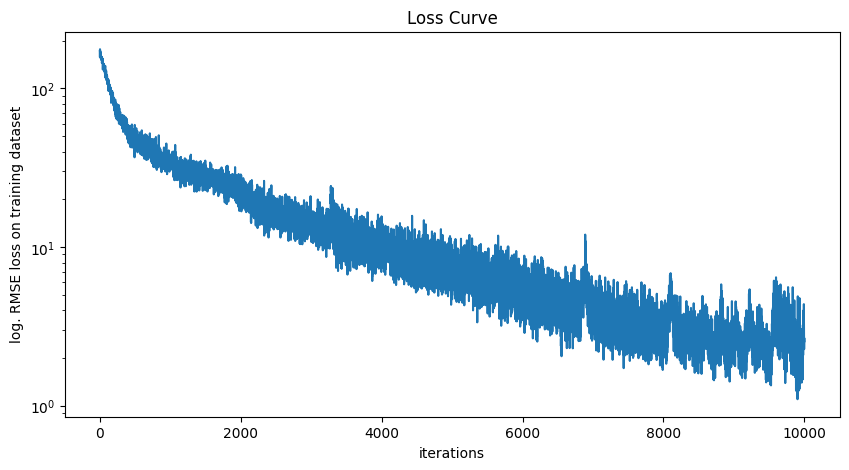

In [163]:
plt.figure(figsize = (10, 5))
plt.plot(np.arange(len(losses)), np.sqrt(losses))
plt.title('Loss Curve')
plt.xlabel('iterations')
plt.ylabel('log. RMSE loss on training dataset')
plt.yscale('log')
plt.show()

In [162]:
torch.save(model.state_dict(), './models/rnn.pt')

## Example with Pipeline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

from src.training import train, investigate_predictions

In [47]:
model = train('002-rnn')

👉 loading config
👉 loading data
   training samples: 122261
   val samples: 30541
👉 training model


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
X, y_preds, y_trues = investigate_predictions('001-rnn')

👉 loading model
👉 loading data
   val samples: 30541
👉 predicting values


In [41]:
X.shape, y_trues.shape

(torch.Size([30541, 12, 1]), torch.Size([30541, 6]))

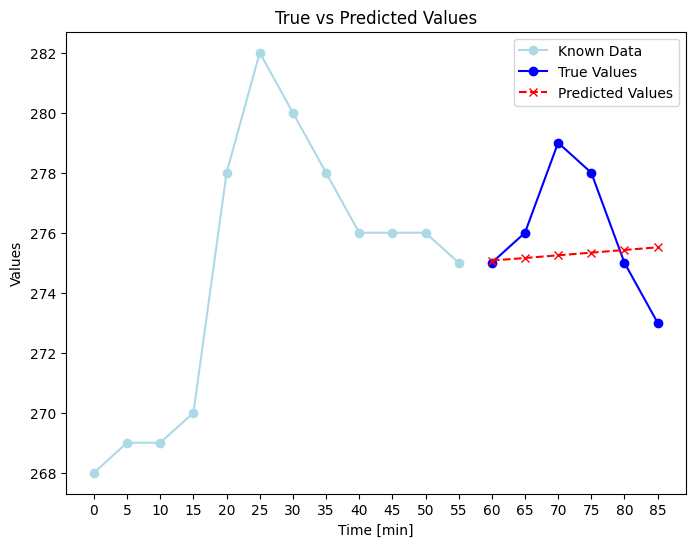

In [56]:
idx = 9900

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Line plot
plt.plot(np.arange(X.shape[1]), X[idx, :, 0], label='Known Data', color='lightblue', linestyle='-', marker='o')
plt.plot(np.arange(X.shape[1], X.shape[1] + y_trues.shape[1]), y_trues[idx].cpu(), label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(np.arange(X.shape[1], X.shape[1] + y_preds.shape[1]), y_preds[idx].cpu(), label='Predicted Values', color='red', linestyle='--', marker='x')

# Labels and title
plt.xlabel('Time [min]')
plt.xticks(np.arange(X.shape[1] + y_preds.shape[1]), np.arange(X.shape[1] + y_preds.shape[1]) * 5)
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()

plt.show()